# Import Required Libraries

In [42]:
import pandas as pd
import numpy as np
import os
import cv2
import tensorflow as tf

import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19, preprocess_input
from keras import Model
from keras.layers import Flatten, Dense, GlobalAveragePooling2D, Input, Lambda
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image_dataset_from_directory

import warnings
warnings.filterwarnings("ignore")

# Load Data

In [5]:
train_dir = "/mnt/hdd/Datasets/Face Mask Dataset/Train"
valid_dir = "/mnt/hdd/Datasets/Face Mask Dataset/Validation"
test_dir = "/mnt/hdd/Datasets/Face Mask Dataset/Test"

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2
)

valid_datagen =  ImageDataGenerator(
    rescale = 1./255
)

test_datagen = ImageDataGenerator(
    rescale = 1./255
)

In [9]:
train_data  = train_datagen.flow_from_directory(
    directory = train_dir,
    target_size = (224, 224),
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True
)

valid_data = valid_datagen.flow_from_directory(
    directory = valid_dir,
    target_size = (224, 224),
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True
)

test_data = test_datagen.flow_from_directory(
    directory = test_dir,
    target_size = (224, 224),
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True
) 

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


In [34]:
files_mask = [test_dir + "/WithMask/" + file for file in os.listdir(test_dir + "/WithMask")]
files_nomask = [test_dir + "/WithoutMask/" + file for file in os.listdir(test_dir + "/WithoutMask")]

In [35]:
files_mask = np.array(files_mask)
files_nomask = np.array(files_nomask)

In [36]:
files_mask = pd.DataFrame({"filepath": files_mask, "label": "mask"})
files_nomask = pd.DataFrame({"filepath": files_nomask, "label": "no mask"})

In [37]:
files = pd.concat([files_mask, files_nomask])
files.head()

,filepath,label
0,/mnt/hdd/Datasets/Face Mask Dataset/Test/WithM...,mask
1,/mnt/hdd/Datasets/Face Mask Dataset/Test/WithM...,mask
2,/mnt/hdd/Datasets/Face Mask Dataset/Test/WithM...,mask
3,/mnt/hdd/Datasets/Face Mask Dataset/Test/WithM...,mask
4,/mnt/hdd/Datasets/Face Mask Dataset/Test/WithM...,mask


In [40]:
def visualize_df(df: pd.DataFrame):
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    for i, ax in enumerate(axes.ravel()):
        if i < len(df):
            img_path, label = df.sample(frac=1).iloc[i][["filepath", "label"]]

            img = plt.imread(img_path)
            ax.imshow(img)
            ax.set_title(label)
            ax.axis("off")
        else:
            ax.axis("off")

    plt.tight_layout()
    plt.show()

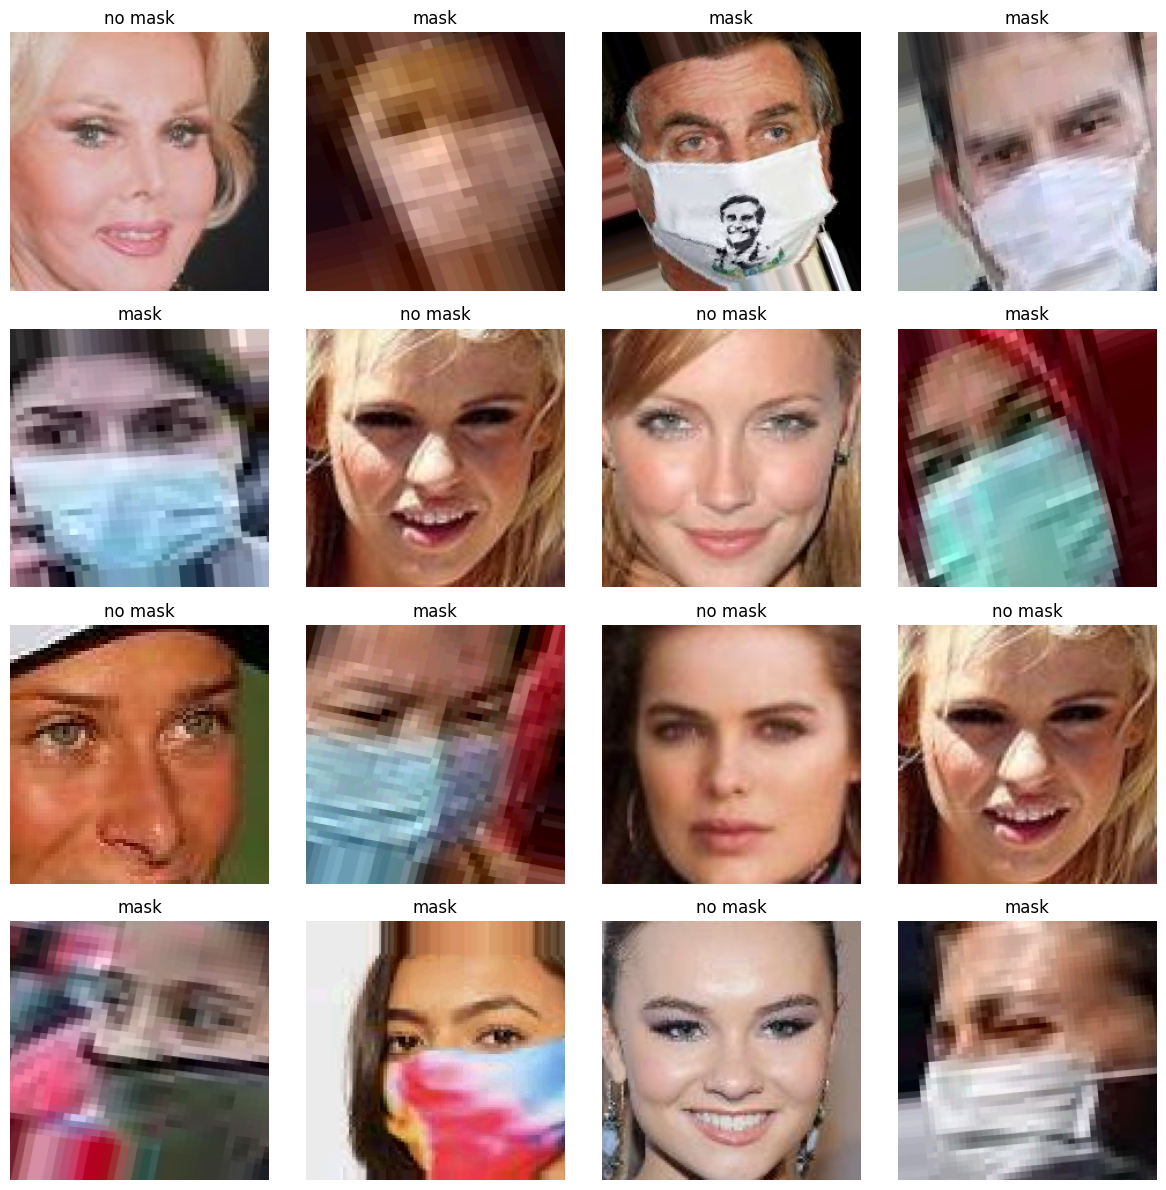

In [41]:
visualize_df(files)

# VGG19

In [43]:
input_layer = Input((224, 224, 3))
preprocessed_inputs = Lambda(lambda x: preprocess_input(x))(input_layer)

In [45]:
base_model = VGG19(
    weights = "imagenet",
    include_top = False,
    input_tensor = preprocessed_inputs
)

In [46]:
for layer in base_model.layers:
    layer.trainable = False

In [48]:
x = Flatten()(base_model.output)
x = Dense(2, activation="sigmoid")(x)

model = Model(inputs=input_layer, outputs=x)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584

In [56]:
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy", "Precision", "Recall", "AUC"])

In [57]:
early_stop = EarlyStopping(monitor="val_loss", patience=5)

In [61]:
history = model.fit(train_data, 
                    steps_per_epoch=train_data.samples // train_data.batch_size,
                    epochs=10,
                    validation_data=valid_data,
                    validation_steps=valid_data.samples // valid_data.batch_size,
                    callbacks = [early_stop])

Epoch 1/10


2023-11-05 17:25:38.918766: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-05 17:25:39.260863: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8904
2023-11-05 17:25:39.354826: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-05 17:25:39.650220: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.74GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-11-05 17:25:40.198542: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were avail

  1/312 [..............................] - ETA: 51:19 - loss: 1.4426 - accuracy: 0.6250 - precision: 0.6250 - recall: 0.6250 - auc: 0.6445

2023-11-05 17:25:47.220531: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fdfdc0c2220 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-05 17:25:47.220559: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2023-11-05 17:25:47.224581: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-05 17:25:47.323120: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


195/312 [=================>............] - ETA: 1:07 - loss: 0.7193 - accuracy: 0.5425 - precision: 0.5398 - recall: 0.5498 - auc: 0.5579

2023-11-05 17:27:40.143622: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.74GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


312/312 [==============================] - 198s 605ms/step - loss: 0.6994 - accuracy: 0.5590 - precision: 0.5552 - recall: 0.5599 - auc: 0.5821 - val_loss: 0.7829 - val_accuracy: 0.5337 - val_precision: 0.5337 - val_recall: 0.5350 - val_auc: 0.6565
Epoch 2/10
312/312 [==============================] - 92s 293ms/step - loss: 0.6547 - accuracy: 0.6083 - precision: 0.6075 - recall: 0.6072 - auc: 0.6543 - val_loss: 0.5950 - val_accuracy: 0.7462 - val_precision: 0.7629 - val_recall: 0.7200 - val_auc: 0.8212
Epoch 3/10
312/312 [==============================] - 93s 296ms/step - loss: 0.6203 - accuracy: 0.6494 - precision: 0.6510 - recall: 0.6501 - auc: 0.7089 - val_loss: 0.5694 - val_accuracy: 0.7075 - val_precision: 0.6960 - val_recall: 0.7212 - val_auc: 0.8056
Epoch 4/10
312/312 [==============================] - 94s 300ms/step - loss: 0.5954 - accuracy: 0.6827 - precision: 0.6825 - recall: 0.6817 - auc: 0.7443 - val_loss: 0.5697 - val_accuracy: 0.6650 - val_precision: 0.6662 - val_recall:

In [127]:
model.save("mask.h5")

In [63]:
history_df = pd.DataFrame(history.history)
history_df.head()

,loss,accuracy,precision,recall,auc,val_loss,val_accuracy,val_precision,val_recall,val_auc
0,0.699397,0.558989,0.555158,0.559892,0.582146,0.782931,0.53375,0.533666,0.53500,0.656512
1,0.654671,0.608347,0.607487,0.607243,0.654250,0.594982,0.74625,0.762914,0.72000,0.821241
2,0.620349,0.649378,0.650995,0.650080,0.708872,0.569361,0.70750,0.696019,0.72125,0.805598
3,0.595437,0.682685,0.682503,0.681681,0.744342,0.569719,0.66500,0.666250,0.66625,0.781505
4,0.573382,0.702949,0.701014,0.700241,0.771820,0.521301,0.79500,0.794743,0.79375,0.880957


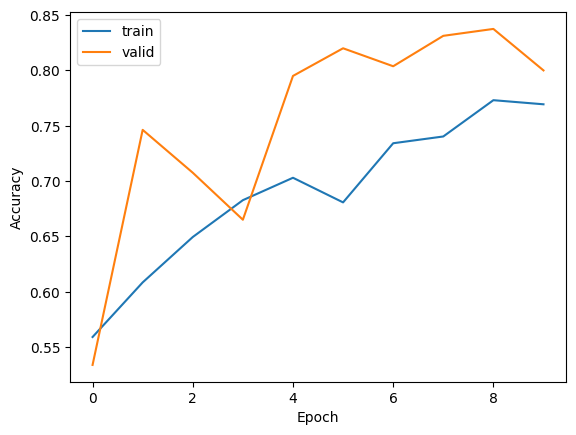

In [64]:
plt.figure()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train", "valid"])
plt.show()

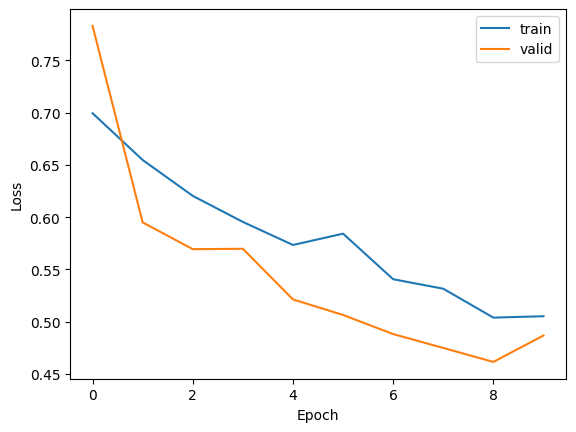

In [65]:
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "valid"])
plt.show()

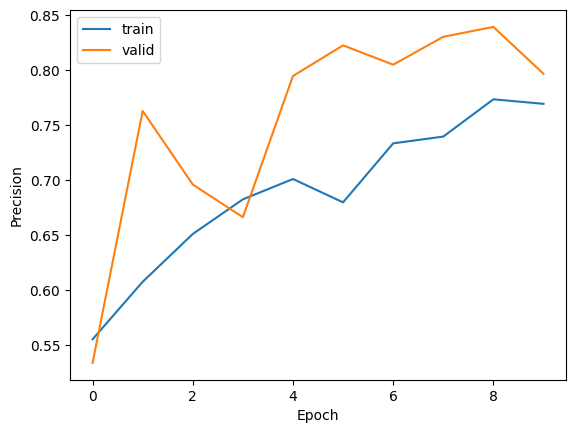

In [66]:
plt.figure()
plt.plot(history.history["precision"])
plt.plot(history.history["val_precision"])
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.legend(["train", "valid"])
plt.show()

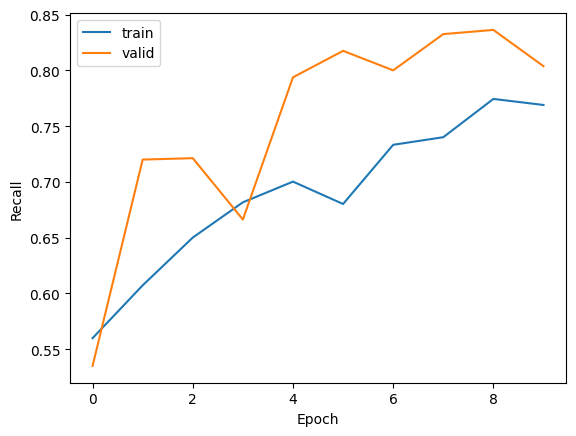

In [67]:
plt.figure()
plt.plot(history.history["recall"])
plt.plot(history.history["val_recall"])
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.legend(["train", "valid"])
plt.show()

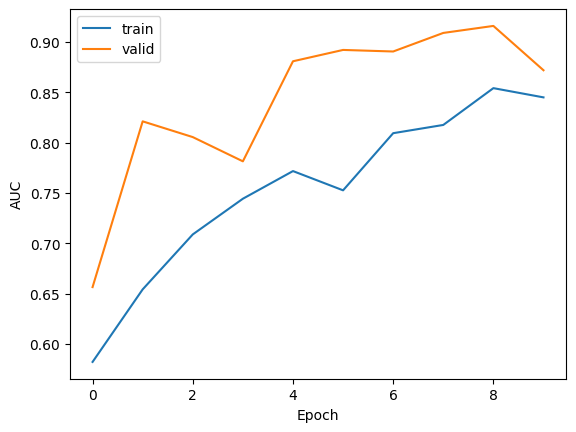

In [68]:
plt.figure()
plt.plot(history.history["auc"])
plt.plot(history.history["val_auc"])
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.legend(["train", "valid"])
plt.show()

In [70]:
test_loss, test_acc, test_precision, test_recall, test_auc = model.evaluate(valid_data)
print("Test loss:", test_loss)
print('Test accuracy:', test_acc)
print("Test precision:", test_precision)
print("Test recall:", test_recall)
print("Test auc:", test_auc)

25/25 [==============================] - 7s 270ms/step - loss: 0.4868 - accuracy: 0.8000 - precision: 0.7968 - recall: 0.8037 - auc: 0.8720
Test loss: 0.4867934286594391
Test accuracy: 0.800000011920929
Test precision: 0.7967782020568848
Test recall: 0.8037499785423279
Test auc: 0.8720328211784363


# Predict

In [71]:
cascade = cv2.CascadeClassifier("/mnt/hdd/Datasets/haarcascades/haarcascade_frontalface_alt.xml")

In [85]:
train_data.class_indices

{'WithMask': 0, 'WithoutMask': 1}

In [115]:
def predict_image(img_path, display=False):
    img = cv2.imread(img_path)
    sample_img = cv2.resize(img, (224, 224))
    sample_img = np.reshape(sample_img, [1, 224, 224, 3])
    sample_img = sample_img / 255.
    pred = model.predict(sample_img)
    result = pred.argmax()
    
    if result == 0:
        result = "mask"
    
    elif result == 1:
        result = "no mask"
    
    gray_img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
    faces = cascade.detectMultiScale(gray_img, 1.1, 3)
    img = cv2.cvtColor(gray_img, cv2.COLOR_BGR2RGB)

    if display:
        for (x, y, w, h) in faces:
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 225, 0), 1)
            cv2.putText(img, result, (x, y + 10), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 255), 1)
        
        plt.figure()
        plt.imshow(img)
        plt.title(result)
        plt.show()

    return result

In [116]:
mask_img_path = "/mnt/hdd/Datasets/Face Mask Dataset/Test/WithMask/3.png"
nomask_img_path = "/mnt/hdd/Datasets/Face Mask Dataset/Test/WithoutMask/1405.png"

1/1 [==============================] - 0s 21ms/step


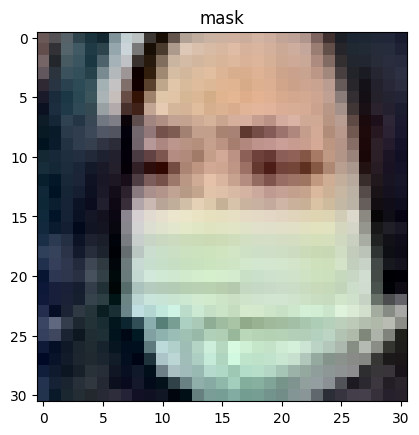

'mask'

In [117]:
predict_image(mask_img_path, True)

1/1 [==============================] - 0s 28ms/step


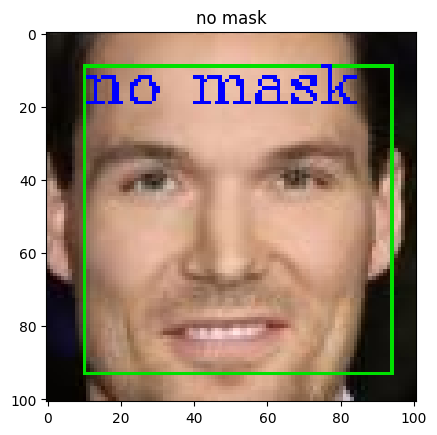

'no mask'

In [118]:
predict_image(nomask_img_path, True)

In [119]:
test_images = files.sample(16).reset_index(drop=True)
test_images

,filepath,label
0,/mnt/hdd/Datasets/Face Mask Dataset/Test/WithM...,mask
1,/mnt/hdd/Datasets/Face Mask Dataset/Test/Witho...,no mask
2,/mnt/hdd/Datasets/Face Mask Dataset/Test/Witho...,no mask
3,/mnt/hdd/Datasets/Face Mask Dataset/Test/WithM...,mask
4,/mnt/hdd/Datasets/Face Mask Dataset/Test/Witho...,no mask
5,/mnt/hdd/Datasets/Face Mask Dataset/Test/WithM...,mask
6,/mnt/hdd/Datasets/Face Mask Dataset/Test/Witho...,no mask
7,/mnt/hdd/Datasets/Face Mask Dataset/Test/Witho...,no mask
8,/mnt/hdd/Datasets/Face Mask Dataset/Test/Witho...,no mask
9,/mnt/hdd/Datasets/Face Mask Dataset/Test/WithM...,mask


In [125]:
def visualize_df(df: pd.DataFrame):
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    for i, ax in enumerate(axes.ravel()):
        if i < len(df):
            img_path, label = df.sample(frac=1).iloc[i][["filepath", "label"]]
            res = predict_image(img_path, display=False)
            img = plt.imread(img_path)
            
            ax.imshow(img)
            ax.set_title(f"Actual: {label}\nPredicted:{res}")
            ax.axis("off")
        else:
            ax.axis("off")

    plt.tight_layout()
    plt.show()

1/1 [==============================] - 0s 14ms/step


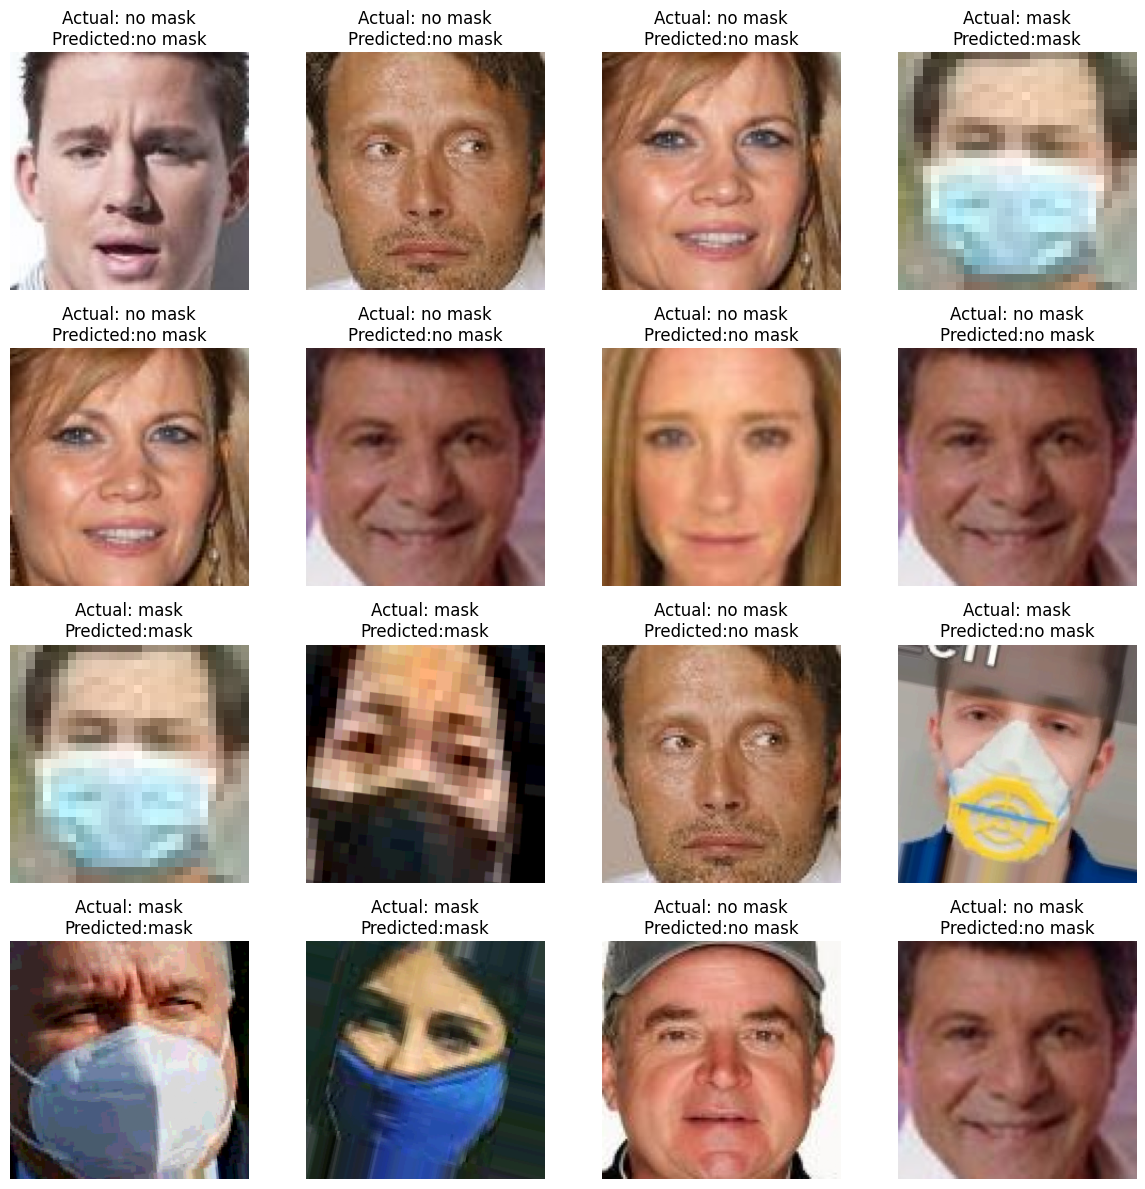

In [126]:
visualize_df(test_images)